# Import packages

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import re
from string import punctuation
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
#nltk.download('words')
import random
import mailparser
import requests

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report # for model evaluation metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Import Enron emails

## Import originally labeled emails

In [97]:
emails_df = pd.DataFrame({"message" : [],
                         "category" : []})
for i in range(1,9):
    path_data = f'../../raw_data/enron/emails/txt_files_categories/all_txt_files{i}.txt'
    with open(path_data) as f:
        contents = f.read()
        emails_cat = ["Message-ID: " + email for email in contents.split("Message-ID: ") if email]
        emails_df = pd.concat([emails_df, pd.DataFrame({"message" : emails_cat,
                         "category" : int(i)})]).reset_index(drop=True)

## Import model-labeled emails

In [98]:
emails_model_df = pd.read_csv("new_emails_labeled.csv")
emails_model_df["category"] = 0

# Import conversational messages

In [99]:
r = requests.get('https://raw.githubusercontent.com/alexa/Topical-Chat/master/conversations/train.json').json()

message_l = []
for key in r.keys():
    for message in r[key]['content']:
        message_l.append(message["message"])
conv_message_df = pd.DataFrame({"body":message_l})
conv_message_df.head()

,body
0,Are you a fan of Google or Microsoft?
1,Both are excellent technology they are helpful...
2,"I'm not a huge fan of Google, but I use it a ..."
3,Google provides online related services and pr...
4,"Yeah, their services are good. I'm just not a ..."


In [100]:
conv_message_df.sample()["body"].values[0]

'I watch some netflix and some hulu every now and then. I just finished the second season for The Handmaids tale.'

## Testing other dataset...

In [101]:
path_data = '../../raw_data/Social Conversation (csv).csv'
df_test = pd.read_csv(path_data, encoding="Latin-1")
df_test.sample()["??"].values[0]

'?? Puma Sneakers for *Rs.1079* [MRP Rs.2699]  *Size 10 Only*  http://amzn.to/2p5DpGX'

In [102]:
path_data = '../../raw_data/Emails.csv'
df_test = pd.read_csv(path_data, encoding="Latin-1")
df_test.sample()["RawText"].values[0]

'UNCLASSIFIED U.S. Department of State Case No. F-2014-20439 Doc No. C05766685 Date: 08/31/2015\nRELEASE IN\nFULL\nFrom: Mills, Cheryl D <MillsCD@state.gov>\nSent: Sunday, January 31, 2010 7:53 AM\nTo: H\nSubject Running a few min late\nUNCLASSIFIED U.S. Department of State Case No. F-2014-20439 Doc No. C05766685 Date: 08/31/2015\n\x0c'

# Parsing emails

In [103]:
def extract_date(email):
    mail = mailparser.parse_from_string(email)
    date = mail.date
    return date

def extract_sender(email):
    mail = mailparser.parse_from_string(email)
    if len(mail.from_) > 0:
        sender = mail.from_[0][1]
    else:
        sender = mail.from_
    return sender

def extract_recipients(email):
    mail = mailparser.parse_from_string(email)
    if len(mail.to) > 0:
        to = ",".join([rec[1] for rec in mail.to])
    else:
        to = mail.to
    return to

def extract_header(email):
    mail = mailparser.parse_from_string(email)
    header = mail.subject
    return header

def extract_body(email):
    mail = mailparser.parse_from_string(email)
    body = mail.body
    return body

**Parsing labeled emails**

In [104]:
emails_df_parsed = pd.DataFrame()
emails_df_parsed["ID"] = emails_df["message"].apply(lambda x: re.search(r'\d+',x)[0])
emails_df_parsed["date"] = emails_df["message"].apply(extract_date)
emails_df_parsed["from"] = emails_df["message"].apply(extract_sender)
emails_df_parsed["to"] = emails_df["message"].apply(extract_recipients)
emails_df_parsed["header"] = emails_df["message"].apply(extract_header)
emails_df_parsed["body"] = emails_df["message"].apply(extract_body)
emails_df_parsed["category"] = emails_df["category"]
emails_df_parsed.head()

Email content 'mixed' not handled
Email content 'mixed' not handled
Email content 'alternative' not handled
Email content 'alternative' not handled
Email content 'mixed' not handled
Email content 'mixed' not handled
Email content 'mixed' not handled
Email content 'mixed' not handled
Email content 'alternative' not handled
Email content 'alternative' not handled
Email content 'mixed' not handled
Email content 'mixed' not handled
Email content 'mixed' not handled
Email content 'mixed' not handled
Email content 'alternative' not handled
Email content 'alternative' not handled
Email content 'mixed' not handled
Email content 'mixed' not handled
Email content 'mixed' not handled
Email content 'mixed' not handled
Email content 'alternative' not handled
Email content 'alternative' not handled
Email content 'mixed' not handled
Email content 'mixed' not handled
Email content 'mixed' not handled
Email content 'mixed' not handled
Email content 'alternative' not handled
Email content 'alternative' 

,ID,date,from,to,header,body,category
0,197504,1999-10-18 08:47:00,steven.kean@enron.com,"mark.schroeder@enron.com,kenneth.lay@enron.com...",Translation of articles,---------------------- Forwarded by Steven J K...,1.0
1,11991339,2001-03-05 16:23:00,drew.fossum@enron.com,darrell.schoolcraft@enron.com,TW Gas Sales: PRIVILEGED AND CONFIDENTIAL ATTO...,In anticipation of potential litigation involv...,1.0
2,7106753,2001-03-06 08:59:00,drew.fossum@enron.com,"julia.white@enron.com,steven.january@enron.com",TW Gas Sales: PRIVILEGED AND CONFIDENTIAL ATTO...,Julia and Steve--here are some questions I've ...,1.0
3,21267718,2001-03-06 19:59:00,drew.fossum@enron.com,"julia.white@enron.com,steven.january@enron.com",TW Gas Sales: PRIVILEGED AND CONFIDENTIAL ATTO...,Julia and Steve--here are some questions I've ...,1.0
4,20866019,2001-03-06 03:23:00,drew.fossum@enron.com,darrell.schoolcraft@enron.com,TW Gas Sales: PRIVILEGED AND CONFIDENTIAL ATTO...,In anticipation of potential litigation involv...,1.0


# EDA emails


In [105]:
num_email_per_cat = emails_df_parsed["category"].value_counts().sort_index()
weight_email_per_cat = emails_df_parsed["category"].value_counts(normalize=True).sort_index()
num_mail_df = pd.DataFrame({"number of emails" : num_email_per_cat.values,
             "% of total" : round(weight_email_per_cat,2)}, index = num_email_per_cat.index)
num_mail_df.loc["Total"] = num_mail_df.sum()
num_mail_df

,number of emails,% of total
1.0,839.0,0.49
2.0,38.0,0.02
3.0,102.0,0.06
4.0,480.0,0.28
5.0,74.0,0.04
6.0,144.0,0.08
7.0,21.0,0.01
8.0,18.0,0.01
Total,1716.0,0.99


Keeping only **business-related** categories and attributing **category 0** for these emails:

In [106]:
emails_business_df = emails_df_parsed[emails_df_parsed["category"].isin([1,4,5,6])][["body","category"]]
emails_business_df["category"] = 0
emails_business_df.head()

,body,category
0,---------------------- Forwarded by Steven J K...,0
1,In anticipation of potential litigation involv...,0
2,Julia and Steve--here are some questions I've ...,0
3,Julia and Steve--here are some questions I've ...,0
4,In anticipation of potential litigation involv...,0


# EDA conversational messages

Affecting **category 1** to conversational messages :

In [107]:
conv_message_df["category"] = 1
conv_message_df.head()

,body,category
0,Are you a fan of Google or Microsoft?,1
1,Both are excellent technology they are helpful...,1
2,"I'm not a huge fan of Google, but I use it a ...",1
3,Google provides online related services and pr...,1
4,"Yeah, their services are good. I'm just not a ...",1


In [108]:
length_message = [len(mess) for mess in conv_message_df["body"]]
print("Average message length :", round(np.average(length_message),0), "characters")

Average message length : 103.0 characters


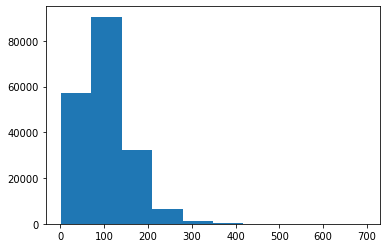

In [109]:
length_message = [len(mess) for mess in conv_message_df["body"]]
plt.hist(length_message);

# Concatenating emails & messages

In [110]:
df = pd.concat([emails_business_df,emails_model_df[["body","category"]],conv_message_df.sample(len(emails_business_df)+len(emails_model_df))], axis=0).reset_index(drop=True)
df.sample(5)

,body,category
4354,"Then again, salaries all over are huge. Loo...",1
4983,These days still ? Really ? It seems like nobo...,1
897,\n\nIn DC to do Lou Pai's speech.\n\nYou speak...,0
2115,---------------------- Forwarded by John Arnol...,0
689,"Felicia,\n\nThis is a merchant asset, which we...",0


In [111]:
df.category.value_counts()

0    3022
1    3022
Name: category, dtype: int64

In [146]:
df.to_csv("message_business_perso.csv")

# Preprocessing

## Cleaning

In [112]:
def clean_email(email):

    # Remove mentions
    email = re.sub(r'@\w+', '', email)
    # Remove urls
    email = re.sub(r'http\S+', ' ', email)
    # Remove digits
    email = re.sub("\d+", " ", email)
    # Remove backline character
    email = email.replace('\n', ' ')
    # Remove forwarded emails
#     email = re.sub("Forwarded by.*$",' ', email)
#     email = re.sub("Original Message.*$",' ', email)
    # Remove digits between brackets
    email = re.sub(r'<.*>', '', email)
    # Remove punctuations
    email = email.translate(str.maketrans(" ", " ", punctuation))
    email = email.lower()
    # Remove some keyword
    elements_to_drop = ['Message-ID:', 'Date:', 'From:', 'To:', 'Subject:', 'Cc:', 'Mime-Version:',
     'Content-Type:', 'Content-Transfer-Encoding:', 'Bcc:', 'X-From:', 'X-To:', 'X-cc:', 'X-bcc:',
     'X-Folder:', 'X-Origin:', 'X-FileName:', 'cc', '\t', '--', 'Sent', ' --', '-', '/', '\n', 'Re:', 'FW:']
    for element in elements_to_drop:
        email = email.replace(element, ' ')

    return email

In [113]:
df_cleaned = df.loc[df["body"].notna()]
df_cleaned["body"] = df_cleaned["body"].apply(clean_email)

## Stopword removal

In [114]:
def stopword_removal(email):

    stop_words = set(stopwords.words('english')) 

    email = email.split()
    filtered_sentence = ""

    for w in email: 
        if w not in stop_words: 
            filtered_sentence = filtered_sentence + w +" "

    return filtered_sentence

def unknown_word(email):
    
    words = set(nltk.corpus.words.words())

    filtered_sentence = " ".join(w for w in nltk.wordpunct_tokenize(sent) if w.lower() in words or not w.isalpha())
    
    return filtered_sentence

In [115]:
df_cleaned["body"] = df_cleaned["body"].apply(stopword_removal)
# df_cleaned["body"] = df_cleaned["body"].apply(unknown_word)

## Tokenizing

In [116]:
df_cleaned["body"] = df_cleaned["body"].apply(word_tokenize)

## Lemmatizing

In [117]:
def lemmatizing(email):
    
    # 1 - Lemmatizing the verbs
    verb_lemmatized = [                  
    WordNetLemmatizer().lemmatize(word, pos = "v") # v --> verbs
    for word in email   
    ]

    # 2 - Lemmatizing the nouns
    noun_lemmatized = [                 
    WordNetLemmatizer().lemmatize(word, pos = "n") # n --> nouns
    for word in verb_lemmatized
    ]
    
    return noun_lemmatized

In [118]:
df_cleaned["body"] = df_cleaned["body"].apply(lemmatizing)

In [119]:
df_cleaned = df_cleaned[df_cleaned["body"].map(lambda d: len(d)) > 0]
df_cleaned["body"] = df_cleaned["body"].apply(lambda x: " ".join(x))

## Example

### Selecting random message number

In [120]:
random_mess = random.randint(0,len(df_cleaned))
random_mess

4583

### Message before preprocessing

In [121]:
df.loc[random_mess,"body"]

'do you play video games?'

### Message after preprocessing

In [122]:
df_cleaned.loc[random_mess,"body"]

'play video game'

# Model

In [123]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df_cleaned["body"], df_cleaned["category"], test_size=0.2)

# Vectorizer
vectorizer = TfidfVectorizer(min_df=0.1,max_df=0.7)
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

# Model
model = MultinomialNB(alpha=0.01)
model.fit(X_train_counts, y_train)
y_pred = model.predict(X_test_counts)

recall = recall_score(y_test, y_pred, average=None)
accuracy = accuracy_score(y_test, y_pred)
print(classification_report(y_test, model.predict(X_test_counts)))

              precision    recall  f1-score   support

           0       0.74      0.98      0.84       607
           1       0.97      0.65      0.78       598

    accuracy                           0.81      1205
   macro avg       0.85      0.81      0.81      1205
weighted avg       0.85      0.81      0.81      1205



## Testing the prediction on the "purely personal" emails

In [128]:
# Keeping only category 4 (personal emails)
emails_perso = emails_df_parsed[emails_df_parsed["category"]==2]
# preprocessing
emails_perso_cleaned = emails_perso.loc[emails_perso["body"].notna()]
emails_perso_cleaned["body"] = emails_perso_cleaned["body"].apply(clean_email)
emails_perso_cleaned["body"] = emails_perso_cleaned["body"].apply(stopword_removal)
emails_perso_cleaned["body"] = emails_perso_cleaned["body"].apply(word_tokenize)
emails_perso_cleaned["body"] = emails_perso_cleaned["body"].apply(lemmatizing)
emails_perso_cleaned = emails_perso_cleaned[emails_perso_cleaned["body"].map(lambda d: len(d)) > 0]
emails_perso_cleaned["body"] = emails_perso_cleaned["body"].apply(lambda x: " ".join(x))

In [127]:
X_perso = emails_perso_cleaned["body"].reset_index(drop=True)
X_perso_vec = vectorizer.transform(X_perso)
y_pred_perso = model.predict(X_perso_vec)
df_pred = pd.DataFrame({"body" : X_perso.values,
             "category_predict" : y_pred_perso})
df_pred

,body,category_predict
0,sorry gang new computer mess email list think ...,1
1,boundary ca b e bef f friday burrito fun fortu...,0
2,preempt please jeff dasovich pm mary hainhouec...,0
3,sue im impress know put link email cant figure...,0
4,great idea,0
...,...,...
92,vince ill email cv id happy speak power risk c...,0
93,first hanukkah three week ago second spell inc...,1
94,jeff speak joannie afternoon ask email send in...,0
95,confidential follow member ask help inventory ...,0


**Personal test** :

In [145]:
text = "schedule a meeting tomorrow?"
text = clean_email(text)
text = stopword_removal(text)
text = word_tokenize(text)
text = lemmatizing(text)
text = " ".join(text)
text_vec = vectorizer.transform(pd.Series(text))
y_pred_text = model.predict(text_vec)
y_pred_text

array([0])